# Analyzing A Movie Review Dataset[100 Points]

## 0. Text Preprocessing [10 Points]

Read through this tutorial on kaggle [here](
https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words) , to
familiarize yourself with its python tools and workflow. You'll have to download "labeledTrainData.tsv" and "testData.tsv" from [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). Please remember to add your GT_UserName in the author function below.

In [1]:
def author(gt_username = 'pburdell3'):
    print("This assignment is submitted by {0}.".format(gt_username))

#Add your GT_UserName below and uncomment the line.
author('sroy86')


This assignment is submitted by sroy86.


In [0]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from copy import deepcopy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import pairwise_distances

In [0]:
# Reading in the data
train = pd.read_csv("labeledTrainData.tsv", delimiter="\t")
test = pd.read_csv("testData.tsv", delimiter="\t")

In [0]:
def preprocess_review(review):
    """Helper function to clean the reviews.

     Arg: review: review text.
     Returns: clean_review : Cleaned reviews

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
     4. Remove stopwords.
    """

    #Write your code below.
    
    ## HTML Tags removal
    clean1=BeautifulSoup(review)  
    
    ## Non-letter characters removal
    clean2=re.sub("[^a-zA-Z]", " ", clean1.get_text()) 
    
    ## Converting to lower case and splitting each word
    clean3=clean2.lower().split()
    
    ## Removing stopwords
    stops = set(stopwords.words("english"))
    clean4=[w for w in clean3 if not w in stops]
    
    ## Returning the reviews with spaces between words
    clean_review=" ".join(clean4)

    
    return clean_review


In [5]:
#Clean the reviews and add them to the list below
cleaned_reviews = []
nltk.download('stopwords')

#Write your code below.
num_reviews = train["review"].size
for i in range(0, num_reviews):
    cr=preprocess_review(train["review"][i])
    cleaned_reviews.append(cr)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 1. Processing Text to create Design Matrices [15 Points]

In [0]:
def design_matrix(cleaned_reviews):
    """ Generate the 4 design matrices X_counts, X_binary, X_tfidf, X_binary_imbalance.

      Args: cleaned_reviews: Cleaned Reviews.
      Returns:
            X_counts: Design Matrix X_counts.
            X_binary: Design Matrix X_binary(Use the X_counts to generate this.)
            X_tfidf:  Design Matrix X_tfidf
            X_binary_imbalance: Design Matrix X_binary_imbalance(use fraction 0.75)
            imbalance_train: Skewed training set(use fraction 0.75)




    """

    #Write your code here.
  
    vectorizer = CountVectorizer(analyzer = "word",   \
                                tokenizer = None,    \
                                preprocessor = None, \
                                stop_words = None,   \
                                max_features = 5000) 

    train_data_features = vectorizer.fit_transform(cleaned_reviews)

    X_counts = train_data_features.toarray()

    X_binary=X_counts

    X_binary[X_binary>0]=1

    transformer = TfidfTransformer()

    X_tfidf = transformer.fit_transform(X_counts).toarray()

    a=X_binary.tolist()

    train['binary']=['-'.join([str(x) for x in my_list]) for my_list in a]

    train_imbalance_df = train.drop(train.query('sentiment == 1').sample(frac=0.75, random_state=0).index)

    X_binary_imbalance_list = list(train_imbalance_df['binary'])

    X_binary_imbalance = np.array([[int(j) for j in i.split('-')] for i in X_binary_imbalance_list])

    imbalance_train = train_imbalance_df[['id', 'sentiment', 'review']]
    

    return X_counts,X_binary,X_tfidf,X_binary_imbalance,imbalance_train

In [7]:
X_counts,X_binary,X_tfidf,X_binary_imbalance,imbalance_train = design_matrix(cleaned_reviews) 
X_counts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
X_binary

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X_binary_imbalance

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 2. Feature Space Similarity Experiment [25(5 + 5 + 15) Points]

In [0]:
# Obtain the label on the original train set and imbalance train set
train_sentiment = train["sentiment"].values
imbalance_train_sentiment = imbalance_train["sentiment"].values

In [0]:
def dist(X, i, j, distance_function = "euclidean"):
    """The distance function returns the (Euclidean) distance between rows i and j of a design matrix.
     Args: X : Design Matrix
           i,j: row IDs
           distance_function: The distance function to be used. Here we are using euclidean
     Returns: The distance between row i and row j.
  
    """
    #Write your code here.
    distance=np.linalg.norm(X[i,:]-X[j,:])

    return distance

In [0]:
def topk(X, k):
    """The topk(X, k) function returns ((i1,j1,d1),...(ik,jk,dk)) where (ix,jx) are the indices of the xth 
     closest pair, and dx is the corresponding distance. You can break ties randomly.
     Args: X : Design Matrix
           k:  Top k
     Returns: top: A list of [row,col,distance]
  
    """
   
    #Write your code here.
    maxdist=0
    toplist=[]
    Xsize=X.shape[0]
    flag=0
    for i in range(Xsize):
        for j in range(i+1, Xsize):
            Dist=dist(X, i, j)
            if len(toplist)<k:
                toplist.append([i, j, Dist])
                toplist.sort(key = lambda x: x[2])
                maxdist=toplist[-1][2]
            elif Dist<maxdist or (Dist==maxdist and np.random.uniform()>0.5):
                toplist.pop()
                toplist.append([i, j, Dist])
                toplist.sort(key = lambda x: x[2])
                maxdist=toplist[-1][2] 
            if maxdist==0 and len(toplist)==k:
                flag=-1
                break
        if flag==-1:
            break

    top = tuple([tuple(i) for i in toplist])
      
    return top

Use topk() to find the closest review pairs for each design matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.

In [14]:
# compute top k for X_counts matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.
#Write your code here.
i, j, Dist=topk(X_counts, 1)[0]
print('Minimum inter-row distance:', Dist)
print('index_1:', i, '; review20_1:', train['review'][i][:20], '; label_1:', train['sentiment'][i])
print('index_2:', j, '; review20_2:', train['review'][j][:20], '; label_2:', train['sentiment'][j])

Minimum inter-row distance: 0.0
index_1: 37 ; review20_1: Dumb is as dumb does ; label_1: 0
index_2: 5536 ; review20_2: Dumb is as dumb does ; label_2: 0


In [15]:
# compute top k for X_binary matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.
#Write your code here.
i, j, Dist=topk(X_binary, 1)[0]
print('Minimum inter-row distance:', Dist)
print('index_1:', i, '; review20_1:', train['review'][i][:20], '; label_1:', train['sentiment'][i])
print('index_2:', j, '; review20_2:', train['review'][j][:20], '; label_2:', train['sentiment'][j])


Minimum inter-row distance: 0.0
index_1: 37 ; review20_1: Dumb is as dumb does ; label_1: 0
index_2: 5536 ; review20_2: Dumb is as dumb does ; label_2: 0


In [16]:
# compute top k for X_tfidf matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.
#Write your code here.
i, j, Dist=topk(X_tfidf, 1)[0]
print('Minimum inter-row distance:', Dist)
print('index_1:', i, '; review20_1:', train['review'][i][:20], '; label_1:', train['sentiment'][i])
print('index_2:', j, '; review20_2:', train['review'][j][:20], '; label_2:', train['sentiment'][j])


Minimum inter-row distance: 0.0
index_1: 37 ; review20_1: Dumb is as dumb does ; label_1: 0
index_2: 5536 ; review20_2: Dumb is as dumb does ; label_2: 0


In [17]:
# compute top k for X_binary_imbalance matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.
#Write your code here.
retained_rows=list(imbalance_train.index)
i, j, Dist=topk(X_binary_imbalance, 1)[0]
i, j=retained_rows[i], retained_rows[j]
print('Minimum inter-row distance:', Dist)
print('index_1:', i, '; review20_1:', train['review'][i][:20], '; label_1:', train['sentiment'][i])
print('index_2:', j, '; review20_2:', train['review'][j][:20], '; label_2:', train['sentiment'][j])

Minimum inter-row distance: 0.0
index_1: 37 ; review20_1: Dumb is as dumb does ; label_1: 0
index_2: 5536 ; review20_2: Dumb is as dumb does ; label_2: 0


Are the pairs always the same?

No, there are data points with similar reviews, so there are multiple instances of zero-distance. Due to computational limitations, we break away from the distance comparision code whenever we see the maximum distance in the list is zero since we know we could not get a sub-zero distance between two points. 

Just like 37-5536 pair has shown to have same review, we actually encounter similar other identical pairs like 326-7336, 428-14579, 531-9467, etc.

So, whether we come up with the same pair or not will depend on how we break tie for those zero-distance instances.

## 3. Classification Experiment [35 Points]

Now you’re going to tune an SVM classifier using each design matrix, and measure the
resultant performance. Read the sklearn [docs](http://scikit-learn.org/stable/modules/cross_validation.html) on cross-validation to see the
methods to use.
*   Set your rng seed to 0 and create an initial learning_set / test_set split of 80-20.
*   Now we want to use a linear SVM (svm.SVC with kernel=linear) and pick the best C value for our classifier.
*   Repeat for each of the four design matrices:
  *  Repeat 30 times:
    *  Pick a random value of C uniformly in the interval (1e-4, 1e4).
    *  Use 5-fold cross-validation to train the SVM.
    *  Estimate and record the F1-Score.
  *  Select the value of C which produced the best F1-Score and find out the F1-Score on the test set using that C.
  *  Retrain the classifier using the entire learning set with this C value.
  *  Submit test set predictions to Kaggle (see the section in the blog, and
make sure you use their test data. You may need to retrain one more
time using all “training data”). Print your Kaggle score.

In [0]:
import matplotlib.pyplot as plt
import random as rd

from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold

### 3.1 Utility Functions [10 (5 + 5) Points]

In [0]:
import time
from warnings import filterwarnings
filterwarnings('ignore')

def calculateF1(X, y, k = 5):
    """calculateF1(X, y, k = 5) return two list which record all randomly selected c(in the interval (1e-4, 1e4))
     and corresponding F1 scores.

     Args: X: Features
           y: Label of sentiment
           k: Number of Cross-validation

     Returns: c_list: List of all c values.
              f1_list: Corresponding F1 Scores.
    """
    rd.seed(0) #Setting a common seed

    #Write your code here.
    start=time.time()
    c_list=[10**i for i in np.random.uniform(-4, 4, 30)]
    f1_list=[]
    kf = KFold(n_splits=k)
    print('itr# Time')
    i=0
    for c in c_list:
        f1score=0.0
        i+=1
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf = svm.LinearSVC(C=c, max_iter=10000)
            clf = clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            f1score+=f1_score(y_test, y_pred_test)/float(k)
        f1_list.append(f1score)
        if i%5==0:
            print(i, time.time()-start)        
        
    return c_list, f1_list

In [0]:
def findBestC(X, y, k = 5):
    """findBestC(X, y, k) return the best performance c, and the improvement(difference between best and worst f1_scores)/
     Args: X: Features
           y: Label of sentiment
           k: Number of Cross-validation
     Returns: c_best: C value with best f1_score.
              improvement: difference between best and worst f1_score.
    """
    #Write your code here. 
    c_list, f1_list = calculateF1(X, y, k)
    f1max = max(f1_list)
    c_best = c_list[f1_list.index(f1max)]
    improvement = f1max - min(f1_list)
    return c_best,improvement

### 3.2 Tune an SVM classifier using X_counts [20 (4*5) Points]

#### 3.2.0 Utility Function

In [0]:
def findImprovement(X,train_sentiment,test_size = 0.2, random_state = 0):
    """ Find the improvement in F1-Score of the design Matrix(X) using previous utility functions and the test_f1_score using the best C.

      Args: X: Design Matrix
            train_sentiment: Sentiments of the training data
            test_size: Split it as 80:20
            random_state: Seed

      Returns:
            c_best: The best possible c value
            improvement: improvement in F1-Score using the design Matrix(X).
            f1_s: Test F1 Score.
            

      You should carry out the following Steps:
      1. Split the data using the above parameters.
      2. Find out the best c and the improvement. (use 5-fold Cross Validation.)
      3. Find out the test f1 score with this c.
    """
    #Write your code here.
    X_train, X_test, y_train, y_test = train_test_split(X, train_sentiment, test_size=test_size, random_state=random_state)
    c_best, improvement = findBestC(X_train, y_train)
    clf = svm.LinearSVC(C=c_best, max_iter=10000)
    clf = clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    f1_s = f1_score(y_test, y_pred_test)   

    return c_best,improvement,f1_s

#### 3.2.1 Tune an SVM classifier using X_counts



In [22]:
#Print the improvement using X_counts and the test f1_score using the best c.
#Write your code here.
c_best,improvement,f1_s = findImprovement(X_counts,train_sentiment)
print('best c:', c_best, '; improvement:', improvement, '; test f1_score:', f1_s)


itr# Time
5 98.57039380073547
10 292.7220823764801
15 401.93008494377136
20 519.6036071777344
25 717.0939176082611
30 931.5495858192444
best c: 0.007510861577617194 ; improvement: 0.05637641720905007 ; test f1_score: 0.8729392842782469


In [0]:
# Retrain the classifier using the entire learning set with c_best
#Write your code here.
clf = svm.LinearSVC(C=c_best, max_iter=10000)
clf = clf.fit(X_counts, train_sentiment)

Submit test set predictions to Kaggle (see the section in the blog, and
make sure you use their test data. You may need to retrain one more
time using all “training data”). Print your Kaggle scores.

In [36]:
#You should do the following steps.
#1. Create bag of words from the test data.
#2. Generate the labels using that test data.
#3. Save the results to the pandas dataframe. For format check the blog.
#4. Submit the results to Kaggle and add the scores here.

# #Write your code here.
cleaned_reviews_test = []

#Write your code below.
num_reviews = test["review"].size
for i in range(0, num_reviews):
    cr=preprocess_review(test["review"][i])
    cleaned_reviews_test.append(cr)

vectorizer = CountVectorizer(analyzer = "word",   \
                            tokenizer = None,    \
                            preprocessor = None, \
                            stop_words = None,   \
                            max_features = 5000) 

test_data_features = vectorizer.fit_transform(cleaned_reviews_test)

X_counts_test = test_data_features.toarray()

X_binary_test=X_counts_test

X_binary_test[X_binary_test>0]=1

transformer = TfidfTransformer()

X_tfidf_test = transformer.fit_transform(X_counts_test).toarray()  

test['sentiment'] = clf.predict(X_counts_test)

test[['id', 'sentiment']].to_csv('counts_test.csv', encoding='utf-8', index=False)

#Uncomment the below lines and add your score.
X_counts_result = 0.55516
print("The Kaggle Score using X_counts is {}".format(X_counts_result))

The Kaggle Score using X_counts is 0.55516


#### 3.2.2 Tune an SVM classifier using X_binary

In [25]:
#Print the improvement using X_binary and the test f1_score using the best c.
#Write your code here.
c_best,improvement,f1_s = findImprovement(X_binary,train_sentiment)
print('best c:', c_best, '; improvement:', improvement, '; test f1_score:', f1_s)

itr# Time
5 139.28588390350342
10 269.8989577293396
15 342.65047121047974
20 531.0666551589966
25 703.6163303852081
30 797.1101348400116
best c: 0.0024125942153262587 ; improvement: 0.0582855521323693 ; test f1_score: 0.8740710986141796


In [0]:
# Retrain the classifier using the entire learning set with c_best
#Write your code here.
clf = svm.LinearSVC(C=c_best, max_iter=10000)
clf = clf.fit(X_binary, train_sentiment)

In [37]:
#Use the the same steps as you did for X_counts and print the kaggle score. Please note that you need to find X_binary_test using the X_counts_test.
#Write your code here.
test['sentiment'] = clf.predict(X_binary_test)
test[['id', 'sentiment']].to_csv('binary_test.csv', encoding='utf-8', index=False)

#Uncomment the below lines and add your score.
X_binary_result = 0.57084
print("The Kaggle Score using X_binary is {}".format(X_binary_result))

The Kaggle Score using X_binary is 0.57084


#### 3.2.3 Tune an SVM classifier using X_tf_idf

In [28]:
#Print the improvement using X_tf_idf and the test f1_score using the best c.
#Write your code here.
c_best,improvement,f1_s = findImprovement(X_tfidf, train_sentiment)
print('best c:', c_best, '; improvement:', improvement, '; test f1_score:', f1_s)

itr# Time
5 205.2684142589569
10 346.64279985427856
15 474.50623846054077
20 499.06809258461
25 527.1646299362183
30 725.3782649040222
best c: 0.21744406337194058 ; improvement: 0.06215956228267838 ; test f1_score: 0.8818200120797262


In [0]:
# Retrain svm using all X_tfidf data
#Write your code here.
clf = svm.LinearSVC(C=c_best, max_iter=10000)
clf = clf.fit(X_tfidf, train_sentiment)

In [38]:
#Use the the same steps as you did for X_counts and print the kaggle score. Please note that you need to find X_tfidf_test using the X_counts_test.

#Write your code here.
test['sentiment'] = clf.predict(X_tfidf_test)
test[['id', 'sentiment']].to_csv('tfidf_test.csv', encoding='utf-8', index=False)

#Uncomment the below lines and add your score.
X_tfidf_result = 0.5784
print("The Kaggle Score using X_tfidf is {}".format(X_tfidf_result))

The Kaggle Score using X_tfidf is 0.5784


#### 3.2.4 Tune an SVM classifier using X_binary_imbalance

In [31]:
#Print the improvement using X_binary_imbalance and the test f1_score using the best c.
#Write your code here.
c_best,improvement,f1_s = findImprovement(X_binary_imbalance, imbalance_train_sentiment)
print('best c:', c_best, '; improvement:', improvement, '; test f1_score:', f1_s)


itr# Time
5 28.88272190093994
10 104.72456789016724
15 198.97556114196777
20 248.45314025878906
25 283.06400299072266
30 358.1304633617401
best c: 0.008920535767622903 ; improvement: 0.214797834552796 ; test f1_score: 0.7139107611548557


In [0]:
# Retrain svm using all X_binary_imbalance data.
#Write your code here.
clf = svm.LinearSVC(C=c_best, max_iter=10000)
clf = clf.fit(X_binary_imbalance, imbalance_train_sentiment)

In [39]:
#Use the the same steps as you did for X_counts and print the kaggle score.

#Write your code here.
test['sentiment'] = clf.predict(X_counts_test)
test[['id', 'sentiment']].to_csv('imbalance_test.csv', encoding='utf-8', index=False)

#Uncomment the below lines and add your score.
X_binary_imbalance_result = 0.5172
print("The Kaggle Score using X_binary_imbalance is {}".format(X_binary_imbalance_result))

The Kaggle Score using X_binary_imbalance is 0.5172


Which design matrix performed best (e.g., which encoding method worked best)?
What was the lift (improvement in F1-Score) between the worst and best cases for each experiment?

Based on Kaggle score, X_tfidf had the best result (0.5784).

With binary imbalance having less data points, the computation time reduced drastically. 

F1-score improvement:

X_counts: 0.05637641720905007

X_binary: 0.0582855521323693 

X_tfidf: 0.06215956228267838 

X_binary_imbalance: 0.214797834552796

Note: Instead of choosing uniformly from [1e-4, 1e4] for c values, I have chosen uniformly from [-4, 4] and raised them to the power of 10 (as suggested by a discussion thread on Piazza). That way, more spectrum of orders of magnitude could be covered. 

##4. Learning Curve Experiment [15(10 + 5) Points]

Using a logistic regression classifier and the design matrix X_counts, generate a learning curve:
*  Set your rng seed to 0 and create an initial learning_set / test_set split of 80-20.
*  Generate a learning curve (xval vs training error) for n=(100, 500, 1000, 2000,3000, 4000, 5000, 7500, 10000, 15000, 20000) training instances.
*  Interpret the learning curve.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

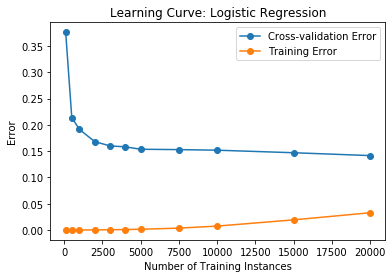

In [35]:
training_instances = [100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000]
#Use the learning_curve module to generate mean train and test scores and plot them with X-axis being the number of training instances and Y-axis.
#Please add appropriate title,labels and legends.
#Write your code here.
train_sizes, train_scores, valid_scores = learning_curve(LogisticRegression(), X_counts, train_sentiment, train_sizes=training_instances, cv=5, random_state=0)

plt.plot(training_instances, [1-sum(i)/len(i) for i in valid_scores], marker='o', label='Cross-validation Error')
plt.plot(training_instances, [1-sum(i)/len(i) for i in train_scores], marker='o', label='Training Error')
plt.legend()
plt.xlabel('Number of Training Instances')
plt.ylabel('Error')
plt.title('Learning Curve: Logistic Regression')
plt.show()


##### Please provide an explanation to the nature of your graph in the above experiment.

The learning curve shows that training error increases with increased training data set. At the same time cv error reduces with increase in training data size and eventually there is a gap between the two. This is an example of a training algorithm that has high variance.